In [6]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [7]:
# set global parameters here

x_f = 2
y_i = 1
g = -9.81
dframe = 0.01 
dx = 0.01
dtheta = 0.01
xs = np.arange(0, x_f+dx, dx)

mu = 0 # coefficient for the friction brachistochrone

# find an appropriate value for theta_f, the angle that the cycloid-generating circle rolls through

test_thetas = np.arange(0.001, 2*math.pi, 0.0001)
# -y_i/x_f = (1 - cos(theta_f) + mu(theta_f + sin(theta_f)))/(theta_f - sin(theta_f)+ mu(1 - cos(theta_f)))
def yx(theta_f):
    return theta_f, (1 - np.cos(theta_f) + mu * (theta_f + np.sin(theta_f)))/(theta_f - np.sin(theta_f) + mu * (1 - np.cos(theta_f)))
theta_fs, yxs  = yx(test_thetas)
theta_f = np.interp(y_i/x_f, np.flip(yxs), np.flip(theta_fs))
thetas = np.arange(0, theta_f+dtheta, dtheta)
r = y_i/(1 - np.cos(theta_f) + mu * (theta_f + np.sin(theta_f))) # radius of the circle

In [8]:
%%capture

# define functions that return (x,y) coordinates as well as f(x) for each path shape

def linear_path(x):
    return x, (-y_i / x_f) * x + y_i

def linear(x):
    return (-y_i / x_f) * x + y_i

def brachistochrone_path(theta, mu=0, r=r):
    return r * (theta - np.sin(theta) + mu * (1 - np.cos(theta))), -r * (1 - np.cos(theta) + mu * (theta + np.sin(theta))) + y_i

# since the brachistochrone is not analytically expressable as f(x), use interpolation to approximate
brachi_path_x, brachi_path_y = brachistochrone_path(thetas)

def brachistochrone(x):
    return np.interp(x, brachi_path_x, brachi_path_y)

def parabola_path(x):
    return x, (y_i/x_f**2) * (x - x_f) ** 2 

def parabola(x):
    return (y_i/x_f**2) * (x - x_f) ** 2 
    

path_funcs = [linear_path, brachistochrone_path, parabola_path]  # functions for our paths
path_names = ['Linear', 'Brachistochrone', 'Parabola']  # names for our paths
path_colors = ['blue', 'green', 'purple']  # colors for our paths

# set up the static plotting environment

y_size = y_i + min(brachi_path_y)

if x_f > y_size:
    fig, ax = plt.subplots(figsize=(13, 13/x_f*y_size))
else:
    fig, ax = plt.subplots(figsize=(9/y_size*x_f, 9))
times = [ax.text(0, 0, 'Time: {:.4f}s'.format(0))] \
  + [ax.text(0, 0.05, 'Linear time: {:.4f}s'.format(0))] \
  + [ax.text(0, 0.1, 'Parabola time: {:.4f}s'.format(0))] \
  + [ax.text(0, 0.15, 'Brach time: {:.4f}s'.format(0))]
paths = [ax.plot([], [], color, markersize=7)[0] for color in ['co', 'yo', 'mo']] + times

ax.set_title('Path Animation (no friction)')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

# define window bounds
ax.set_xlim(-0.1, x_f + 0.1)
ax.set_ylim(min(brachi_path_y)-0.1, y_i + 0.1)

# create origin axes
ax.axhline(0.0, c='grey', alpha=0.5)
ax.axvline(0.0, c='grey', alpha=0.5)

# plot static paths
for i in range(len(path_funcs)):
    if path_funcs[i] == brachistochrone_path:
        ax.plot(path_funcs[i](thetas)[0], path_funcs[i](thetas)[1], c=path_colors[i], label=path_names[i])
    else:
        ax.plot(path_funcs[i](xs)[0], path_funcs[i](xs)[1], c=path_colors[i], label=path_names[i])
ax.legend()

In [9]:
def move(path):
    """Record x-pos, y-pos, and time as a point slides down a defined path."""
    y = y_i
    t = 0
    sim_xs, sim_ys, sim_ts = [], [], []
    # step forward in uniform increments of x
    for x in xs[1:]:
        sim_xs.append(x)
        y_old = y
        # compute y = f(x)
        y = path(x)
        sim_ys.append(y)
        # find change in y corresponding to change in x
        dy = y - y_old
        # by Pythagorean Theorem
        ds = math.sqrt(dx**2 + dy**2)

        # v^2 = 2g(y_i-y) from conservation of energy
        v_old = math.sqrt(2* -g * (y_i-y_old))
        v = math.sqrt(2 * -g * (y_i-y))
        # take the average of v at new and old x
        v_mid = (v_old + v)/2
        
        # add to elapsed time
        dt = ds/v_mid
        t += dt
        sim_ts.append(t)
    return [0]+sim_xs+[x_f], [y_i]+sim_ys+[0], [0]+sim_ts+[t+dt]

def update(frame):
    """Update plot for animation."""
    epsilon = 0.005
    for i, (path, data) in enumerate(zip(paths[:len(path_funcs)], path_data)):
        path.set_data(data[0][frame], data[1][frame])
    paths[len(path_funcs)].set_text('Time: {:.4f}s'.format(ts[frame]))
    if lin_t[-1] - epsilon <= ts[frame] <= lin_t[-1] + epsilon:
      paths[len(path_funcs) + 1].set_text('Linear time: {:.4f}s'.format(lin_t[-1]))
    elif para_t[-1] - epsilon <= ts[frame] <= para_t[-1] + epsilon:
      paths[len(path_funcs) + 2].set_text('Parabola time: {:.4f}s'.format(para_t[-1]))
    if brachi_t[-1] - epsilon <= ts[frame] <= brachi_t[-1] + epsilon:
      paths[len(path_funcs) + 3].set_text('Brachi time: {:.4f}s'.format(brachi_t[-1]))
    return paths

# record the x-pos, y-pos, and time for movement along each path shape

lin_x, lin_y, lin_t = move(linear)
brachi_x, brachi_y, brachi_t = move(brachistochrone)
para_x, para_y, para_t = move(parabola)

# to find x and y at uniform time steps, interpolate
# print(lin_t[-1], brachi_t[-1], para_t[-1])
max_t =  max(lin_t[-1], brachi_t[-1], para_t[-1]) + 0.1 # time taken by the slowest path plus a buffer
ts = np.arange(0, max_t+dframe, dframe)

lin_xt, lin_yt = np.interp(ts, lin_t, lin_x), np.interp(ts, lin_t, lin_y)
brachi_xt, brachi_yt = np.interp(ts, brachi_t, brachi_x), np.interp(ts, brachi_t, brachi_y)
para_xt, para_yt = np.interp(ts, para_t, para_x), np.interp(ts, para_t, para_y)

path_data = [[lin_xt, lin_yt], [brachi_xt, brachi_yt], [para_xt, para_yt]]

In [10]:
# produce the animation (may take a few seconds)

ani = animation.FuncAnimation(fig, update, frames=[frame for frame in range(len(ts))], interval=70, blit=True)

HTML(ani.to_jshtml())

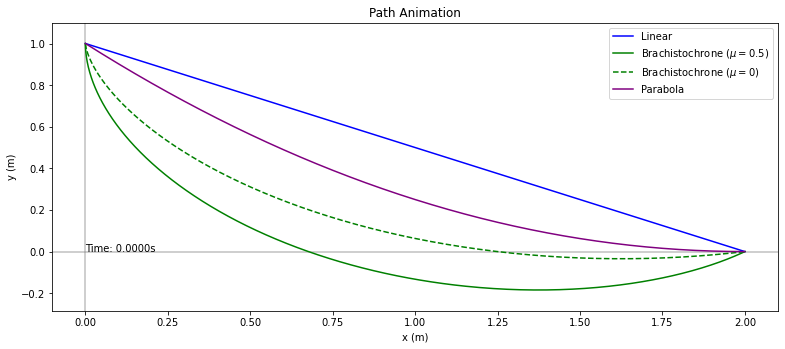

In [11]:
# plot the friction brachistochrone

mu = 0.5

# find an appropriate value for theta_f, the angle that the cycloid-generating circle rolls through
theta_fs_fric, yxs_fric  = yx(test_thetas)
theta_f_fric = np.interp(y_i/x_f, np.flip(yxs_fric), np.flip(theta_fs_fric))
thetas_fric = np.arange(0, theta_f_fric+dtheta, dtheta)
r_fric = y_i/(1 - np.cos(theta_f_fric) + mu * (theta_f_fric + np.sin(theta_f_fric))) # radius of the circle

path_funcs = [linear_path, brachistochrone_path, brachistochrone_path, parabola_path]  # functions for our paths
path_names = ['Linear', 'Brachistochrone ($\mu=0.5$)', 'Brachistochrone ($\mu=0$)', 'Parabola']  # names for our paths
path_colors = ['blue', 'green', 'green', 'purple']  # colors for our paths

# set up the static plotting environment

_, brachi_path_y_fric = brachistochrone_path(thetas_fric, mu=mu, r=r_fric)
y_size = y_i + min(brachi_path_y_fric)

if x_f > y_size:
    fig, ax = plt.subplots(figsize=(13, 13/x_f*y_size))
else:
    fig, ax = plt.subplots(figsize=(9/y_size*x_f, 9))
times = [ax.text(0, 0, 'Time: {:.4f}s'.format(0))]
paths = [ax.plot([], [], color, markersize=7)[0] for color in ['co', 'yo', 'mo']] + times

ax.set_title('Path Animation')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

# define window bounds
ax.set_xlim(-0.1, x_f + 0.1)
ax.set_ylim(min(brachi_path_y_fric)-0.1, y_i + 0.1)

# create origin axes
ax.axhline(0.0, c='grey', alpha=0.5)
ax.axvline(0.0, c='grey', alpha=0.5)

# plot static paths
ax.plot(path_funcs[0](xs)[0], path_funcs[0](xs)[1], c=path_colors[0], label=path_names[0])
ax.plot(path_funcs[1](thetas_fric, mu=mu, r=r_fric)[0], path_funcs[1](thetas_fric, mu=mu, r=r_fric)[1], c=path_colors[1], label=path_names[1])
ax.plot(path_funcs[2](thetas)[0], path_funcs[2](thetas)[1], c=path_colors[2], label=path_names[2], linestyle='--')
ax.plot(path_funcs[3](xs)[0], path_funcs[3](xs)[1], c=path_colors[3], label=path_names[3])       
ax.legend()